# Modeling: Predicting successful Kickstarter Campaigns 

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd
import os
from datetime import datetime
import time
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import metrics

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
ks = pd.read_csv("/Users/JamesW/Desktop/Github Repository/dataforgood/data/ks-projects-201801.csv")

## Create New Variables 

In [3]:
ks["success"] = np.where(ks['state'] == 'successful', True, False)
ks['launched'] = pd.to_datetime(ks['launched'])
ks['deadline'] = pd.to_datetime(ks['deadline'])
ks['campaign_length']= (ks.deadline -ks.launched).astype(str).str.slice(0,2).astype(int)
ks['SeasonOfLaunch'] = pd.cut(
    (ks.launched.dt.dayofyear + 11) % 366,
    [0, 91, 183, 275, 366],
    labels=['Winter', 'Spring', 'Summer', 'Fall']
)
ks['TimeOfDayOfLaunch'] = pd.cut(
    (ks.launched.dt.hour),
    [-1 ,5, 10, 17, 24],
    labels=['Late Night','Morning', 'Afternoon', 'Evening']
)
ks['year'] = ks.launched.dt.year
ks['hourofday'] = ks.launched.dt.hour
ks['length_chars'] = ks.name.str.len()
ks['word_count'] = ks['name'].str.split().str.len()
ks['contains_!'] = pd.get_dummies(ks.name.str.contains('!'), drop_first=True)
ks['contains_title'] = pd.get_dummies(ks.name.str.istitle(), drop_first=True)

## Clean and subset data set for prediction 

In [4]:
ks = ks.reset_index(drop=True)
ks.dropna(inplace = True) # REMOVE NAS
features = ks.drop(['success'],axis=1) # remove prediction column
# drop features we can not use in prediction 
features = features.drop(['pledged','ID','name','deadline','launched','backers',
                          'usd pledged', 'usd_pledged_real','state'],axis=1)

We must remove variables like pledged, state, and backers, as they would not be know until after the campaign has finished. 

In [5]:
features.head(3)

,category,main_category,currency,goal,country,usd_goal_real,campaign_length,SeasonOfLaunch,TimeOfDayOfLaunch,year,hourofday,length_chars,word_count,contains_!,contains_title
0,Poetry,Publishing,GBP,1000.0,GB,1533.95,58,Summer,Afternoon,2015,12,31.0,6.0,0,0
1,Narrative Film,Film & Video,USD,30000.0,US,30000.00,59,Summer,Late Night,2017,4,45.0,8.0,0,0
2,Narrative Film,Film & Video,USD,45000.0,US,45000.00,44,Winter,Late Night,2013,0,14.0,3.0,0,0


## Encode Varaibles for prediction purposes 

In [6]:
label_encoder = LabelEncoder()
features["main_category"] = label_encoder.fit_transform(array(features["main_category"]))
features["category"] = label_encoder.fit_transform(array(features["category"]))
features["currency"] = label_encoder.fit_transform(array(features["currency"]))
features["country"] = label_encoder.fit_transform(array(features["country"]))
features["SeasonOfLaunch"] = label_encoder.fit_transform(array(features["SeasonOfLaunch"]))
features["TimeOfDayOfLaunch"] = label_encoder.fit_transform(array(features["TimeOfDayOfLaunch"]))
features["length_chars"] = label_encoder.fit_transform(array(features["length_chars"]))
features["contains_!"] = label_encoder.fit_transform(array(features["contains_!"]))
features["contains_title"] = label_encoder.fit_transform(array(features["contains_title"]))
features["word_count"] = label_encoder.fit_transform(array(features["word_count"]))
# Saving feature names for later use
feature_list = list(features.columns)
features.head(3)

,category,main_category,currency,goal,country,usd_goal_real,campaign_length,SeasonOfLaunch,TimeOfDayOfLaunch,year,hourofday,length_chars,word_count,contains_!,contains_title
0,108,12,5,1000.0,9,1533.95,58,2,0,2015,12,30,5,0,0
1,93,6,13,30000.0,21,30000.00,59,2,2,2017,4,44,7,0,0
2,93,6,13,45000.0,21,45000.00,44,3,2,2013,0,13,2,0,0


## Split data into test and training sets 
###  70% training and 30% test

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(features,ks.success, test_size=0.3, random_state = 22)

## Build Random Forrest Classifier
After multiple attempts with models, we decided upon using a Random Forrest to predict success. 

In [8]:
rf = RandomForestClassifier(n_estimators = 100)

In [9]:
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
Y_pred=rf.predict(X_test)

## Model Accuracy, how often is the classifier correct?

In [11]:
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.6939898985400095


## Feature Importance
Our models originally had a few more feature variables that did little to help with prediction. This final model demonstrates a middle ground where we used features that had at least a 1% importance value for prediction. 


In [12]:
feature_imp = pd.Series(rf.feature_importances_,index=features.columns).sort_values(ascending=False)
feature_imp

length_chars         0.124634
usd_goal_real        0.120392
category             0.114312
goal                 0.104782
campaign_length      0.092728
hourofday            0.090886
main_category        0.075141
word_count           0.070560
year                 0.065774
SeasonOfLaunch       0.053699
TimeOfDayOfLaunch    0.026425
contains_title       0.021301
country              0.014582
currency             0.013415
contains_!           0.011369
dtype: float64

No handles with labels found to put in legend.


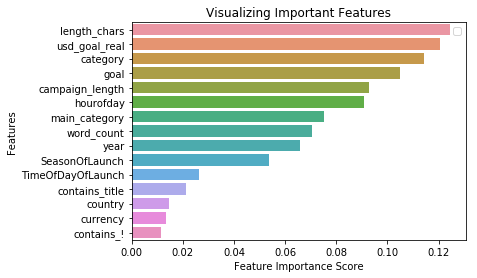

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Cross Validation and Model Assessment 

In [14]:
scores = cross_val_score(rf, features, ks.success, cv=10)
print(scores)
print()
print('Average:', np.mean(scores))

[0.69821758 0.69645386 0.69470871 0.69770176 0.69412079 0.69444148
 0.69422769 0.69163549 0.69398717 0.69698022]

Average: 0.6952474754905366


Average fold of 68% 

In [15]:
print(confusion_matrix(Y_test, Y_pred))

[[61682 10521]
 [23832 16226]]


In [16]:
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

      False       0.72      0.85      0.78     72203
       True       0.61      0.41      0.49     40058

avg / total       0.68      0.69      0.68    112261



## Our model has a great rate of predicting failing kickstarters (85%), and a poor rate of predicting successful kickstarters (41%) 
### This means that it is easy to help kickstarters know whether or not they will fail at the start, but not if they will succeed in the long run. Its up to chance and a good product!  